In [3]:
import numpy as np
import galois
import imageio.v3 as iio
import matplotlib.pyplot as plt
# import hmac
# import hashlib

# Define the binary field GF(2)
GF2 = galois.GF(2)

# Define the irreducible polynomial used to construct GF(2^8)
# Polynomial: x^8 + x^4 + x^3 + x + 1 (represented by the binary vector)
irreducible_poly = galois.Poly([1,0,0,0,1,1,0,1,1], field = GF2)

# Define the extension field GF(2^8) using the given irreducible polynomial
Gfield = galois.GF(2**8, irreducible_poly = irreducible_poly)

## Shift rows

In [4]:
def shiftRows(stateMatrix):

    # Applies AES ShiftRows step: 
    # Each row is cyclically shifted to the left by its row index
    return Gfield(np.array([np.roll(row, shift = -i) for i, row in enumerate(stateMatrix)]))

## Add round key

In [5]:
def addRoundKey(stateMatrix, w, i):

    # XOR the current state matrix with the round key extracted from w
    # w is the key schedule, and i is the round number
    return stateMatrix + w[i * 4: i*4 + 4, :].transpose()

## Mix columns

In [6]:

def mixColumns(stateMatrix):

    # Applies AES MixColumns transformation
    # Each column of the state is multiplied by a fixed matrix (defined below)
    A = Gfield(np.array([[0x02, 0x03, 0x01, 0x01],
                         [0x01, 0x02, 0x03, 0x01],
                         [0x01, 0x01, 0x02, 0x03],
                         [0x03, 0x01, 0x01, 0x02]]))
    
    # Matrix multiplication in GF(2^8)
    return A @ stateMatrix

## Sub bytes

In [7]:
def getIndexFromHex(input):

    # Extracts row and column index from a byte
    # Upper 4 bits = row index, lower 4 bits = column index
    return (input & 0xF0) >> 4, input & 0xF

# 16x16 AES substitution box (S-box) used for the SubBytes step
# Maps each byte to a nonlinear substitution value
sbox = np.array([
                [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76],
                [0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0],
                [0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15],
                [0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75],
                [0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84],
                [0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF],
                [0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8],
                [0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2],
                [0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73],
                [0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB],
                [0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79],
                [0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08],
                [0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A],
                [0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E],
                [0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF],
                [0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16],
                ]) # Full S-box omitted here for brevity; already correctly defined


def subBytes(stateMatrix):
    
    # Applies the AES SubBytes step using the S-box
    for i in range(np.shape(stateMatrix)[0]):
        for j in range(np.shape(stateMatrix)[1]):
            x, y = getIndexFromHex(stateMatrix[i, j])
            stateMatrix[i, j] = sbox[x, y]
    return stateMatrix

ref: https://gist.github.com/bonsaiviking/5571001

## Key expansion

In [8]:
def keyExpansion(key): 
    Nk = 4   #number of columns in state (Number of 32-bit words in the key (AES-128 uses 4)
    Nb = 4   #number of 32 bit words in cipher key (Number of columns (words) in the state matrix)
    Nr = 10  #number of rounds for AES-128
    
    # Initialize the key schedule matrix (44 words × 4 bytes = 176 bytes
    w = np.zeros((44, 4), dtype = int)
    
    # First Nk words are taken directly from the original cipher key
    w[:Nk, :] = key.reshape(4,4)
    
    i = Nk
    while i < Nb * (Nr + 1):
        # Copy previous word
        temp = Gfield(w[i - 1,:]) 
        
        if i % Nk == 0:

            # Perform key schedule core:
            # 1. Rotate left (RotWord)
            afterRotWord = np.roll(temp, -1)

            # 2. Apply SubWord (byte-wise substitution using S-box)
            afterSubWord = subWord(afterRotWord)

            # 3. XOR with round constant
            temp = Gfield(afterSubWord) + Gfield(roundConstant(i//Nk))

        # w[i] = w[i - Nk] XOR temp
        w[i, :] = Gfield(w[i - Nk,:]) + temp
        i += 1
    return w

def roundConstant(i):
    if i == 1:
        # First round constant is 0x01 followed by 0s
        return Gfield(np.array([0x01, 0x0, 0x0, 0x0]))
    
    # Subsequent constants are powers of 0x02 in GF(2^8)
    array = Gfield(np.array([0x02, 0x0, 0x0, 0x0]))
    return array**(i-1)

def subWord(vector):

    # Applies the AES S-box substitution to a 4-byte word
    for i in range(np.shape(vector)[0]):
        x, y = getIndexFromHex(vector[i])
        vector[i] = sbox[x, y]
    return vector

## AES Encrypt

In [9]:
def printInHex(stateMatrix):
    # Prints the 4×4 state matrix in hexadecimal format for visualization
    for row in stateMatrix:
        print(" ".join(f"{val:02x}" for val in row))
    print("\n")

def aesEncrypt(stateMatrix, key):

    # Expand the key into round keys using keyExpansion
    # w has shape (44, 4), 11 round keys of 4 words (4x4 each)
    w = Gfield(keyExpansion(key))

    # Initial AddRoundKey step before the first round
    stateMatrix = stateMatrix + w[:4,:4].transpose()   

    
    # Perform 9 full rounds: SubBytes, ShiftRows, MixColumns, AddRoundKey
    for i in range(1, 10):

        # Byte-wise substitution using S-box
        stateMatrix = subBytes(stateMatrix)
     
        # Rotate rows to the left
        stateMatrix = shiftRows(stateMatrix)
    
        # Mix columns using linear transformation
        stateMatrix = mixColumns(stateMatrix)
     
        # XOR with round key for round i
        stateMatrix = addRoundKey(stateMatrix, w, i)
    
    # Final (10th) round – no MixColumns
    stateMatrix = subBytes(stateMatrix)
    stateMatrix = shiftRows(stateMatrix)

    # Final AddRoundKey
    stateMatrix += w[10 * 4: 10 * 4 + 4, :].transpose()

    # Encrypted state (ciphertext)
    return stateMatrix

## Counter mode

In [20]:
def printVectorHex(vector):
    # Prints a 1D vector in hexadecimal format
    print(" ".join(f"{int(val):02x}" for val in vector))

def counterMode(message, key, nonce):

    # Flatten the message to an array of bytes
    temp = message.flatten()

    # Prepare an empty output array in GF(2^8)
    output = Gfield(np.array([], dtype=int))

    # Pad the message so its length is a multiple of 16 bytes (AES block size)
    if len(temp) % 16 != 0:
        temp = np.append(temp, np.zeros(16 - len(temp) % 16, dtype=int))

    # Process each 16-byte block of the message
    for i in range(len(temp) // 16):
        # Convert current nonce to a 16-byte array and reshape as 4×4 state matrix
        nonceAsMatrix = Gfield(np.array(list(nonce.to_bytes(16, 'big'))).reshape(4, 4)).T

        # Encrypt the nonce using AES
        encrypted = aesEncrypt(nonceAsMatrix, key).T

        # Extract current plaintext block and reshape into a 4×4 matrix
        stateMatrix = temp[i * 16 : (i + 1) * 16].reshape(4, 4)

        # XOR the AES-encrypted nonce with the plaintext block (as in CTR mode)
        output = np.append(output, (Gfield(encrypted) + Gfield(stateMatrix)).flatten())

        # Increment nonce for the next block
        nonce += 1

    # Remove padding to match original message length
    output = output.flatten()

    output = output[:message.size] 
 
    return output





## Test

In [21]:
def printInHex(stateMatrix):

    # Prints the 4×4 state matrix in hexadecimal format for visualization
    for row in stateMatrix:
        print(" ".join(f"{val:02x}" for val in row))
    print("\n")
        
def runTest():
    # Example plaintext in a 4×4 state matrix format
    stateMatrix = Gfield(np.array([[0x32, 0x88, 0x31, 0xe0],
                                   [0x43, 0x5a, 0x31, 0x37],
                                   [0xf6, 0x30, 0x98, 0x07],
                                   [0xa8, 0x8d, 0xa2, 0x34]]))
    
    # stateMatrix = Gfield(np.array([[0x41, 0x6c, 0x66, 0x62],
    #                                [0x65, 0x64, 0x00, 0x00],
    #                                [0x00, 0x00, 0x00, 0x00],
    #                                [0x00, 0x00, 0x00, 0x00]]))
    
    # AES-128 key (16 bytes)
    testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

    # Encrypt using AES
    encrypted = aesEncrypt(stateMatrix, testKey)

    # Display original and encrypted matrices
    # printInHex(stateMatrix)
    # printInHex(encrypted)

def runCounterModeTest():
    message ="""Brian, top marks for not trying
                So kind of you to bless us with your effortlessness
                We're grateful and so strangely comforted


                And I wonder, are you putting us under?
                'Cause we can't take our eyes off the t-shirt and ties combination
                Well, see you later, innovator

                Some want to kiss, some want to kick you
                There's not a net you couldn't slip through
                Or at least that's the impression I get, 'cause you're smooth and you're wet
                And she's not aware yet, but she's yours
                She'll be saying, "Use me, show me the jacuzzi"
                I imagine that it's there on a plate, your high rendezvous rate
                Means that you'll never be frightened to make 'em wait for a while

                I doubt it's your style not to get
                What you set out to acquire, the eyes are on fire
                You are the unforecasted storm, oh"""
    print("Message: \n", message) 
    print()

    # AES-128 test key
    testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

    # Convert message to byte array (as integers)
    messageAsInt = np.array([byte for byte in message.encode("utf-8")])

    # Encrypt using CTR mode (encryption and decryption are symmetric in CTR)
    cypherText = counterMode(messageAsInt, testKey, 1)

    # Convert ciphertext to UTF-8-safe printable string
    cypherTextBytes = bytes([int(x) for x in cypherText])
    cypherTextString = cypherTextBytes.decode('utf-8', errors='replace')
    print("Cypher Text: \n", cypherTextString)
    print()

    # Decrypt (re-encrypt with same key and nonce)
    decryptedText = counterMode(cypherText, testKey, 1)   

    decrypted_bytes = bytes([int(x) for x in decryptedText])
    decrypted_str = decrypted_bytes.decode('utf-8', errors='replace')
    print("Decrypted String: \n", decrypted_str)
  
    
#runTest()
runCounterModeTest()

Message: 
 Brian, top marks for not trying
                So kind of you to bless us with your effortlessness
                We're grateful and so strangely comforted


                And I wonder, are you putting us under?
                'Cause we can't take our eyes off the t-shirt and ties combination
                Well, see you later, innovator

                Some want to kiss, some want to kick you
                There's not a net you couldn't slip through
                Or at least that's the impression I get, 'cause you're smooth and you're wet
                And she's not aware yet, but she's yours
                She'll be saying, "Use me, show me the jacuzzi"
                I imagine that it's there on a plate, your high rendezvous rate
                Means that you'll never be frightened to make 'em wait for a while

                I doubt it's your style not to get
                What you set out to acquire, the eyes are on fire
                You are the un

## Counter mode test

In [19]:
# Convert the nonce integer into a 4x4 matrix of bytes (little-endian order)
nonce = 0xf0f1f2f3f4f5f6f7f8f9fafbfcfdfeff
testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))
plainText = Gfield(np.array([0x6b,0xc1,0xbe,0xe2,0x2e,0x40,0x9f,0x96,0xe9,0x3d,0x7e,0x11,0x73,0x93,0x17,0x2a,
                            0xae, 0x2d, 0x8a, 0x57, 0x1e, 0x03, 0xac, 0x9c, 0x9e, 0xb7, 0x6f, 0xac, 0x45, 0xaf, 0x8e, 0x51,
                            0x30, 0xc8, 0x1c, 0x46, 0xa3, 0x5c, 0xe4, 0x11, 0xe5, 0xfb, 0xc1, 0x19, 0x1a, 0x0a, 0x52, 0xef,
                            0xf6, 0x9f, 0x24, 0x45, 0xdf, 0x4f, 0x9b, 0x17, 0xad, 0x2b, 0x41, 0x7b, 0xe6, 0x6c, 0x37, 0x10]))
cypherText = counterMode(plainText, testKey, nonce)

print("Plaintext:")
for i in range(0,4):
    printVectorHex(plainText[i*16:(i + 1)*16])

print("Ciphertext:")
for i in range(0,4):
    printVectorHex(cypherText[i*16:(i + 1)*16])

Input:
f0 f4 f8 fc f1 f5 f9 fd f2 f6 fa fe f3 f7 fb ff
Output:
ec 8c df 73 98 60 7c b0 f2 d2 16 75 ea 9e a1 e4
Input:
f0 f4 f8 fc f1 f5 f9 fd f2 f6 fa ff f3 f7 fb 00
Output:
36 2b 7c 3c 67 73 51 63 18 a0 77 d7 fc 50 73 ae
Input:
f0 f4 f8 fc f1 f5 f9 fd f2 f6 fa ff f3 f7 fb 01
Output:
6a 2c c3 78 78 89 37 4f be b4 c8 1b 17 ba 6c 44
Input:
f0 f4 f8 fc f1 f5 f9 fd f2 f6 fa ff f3 f7 fb 02
Output:
e8 9c 39 9f f0 f1 98 c6 d4 0a 31 db 15 6c ab fe
Plaintext:
6b c1 be e2 2e 40 9f 96 e9 3d 7e 11 73 93 17 2a
ae 2d 8a 57 1e 03 ac 9c 9e b7 6f ac 45 af 8e 51
30 c8 1c 46 a3 5c e4 11 e5 fb c1 19 1a 0a 52 ef
f6 9f 24 45 df 4f 9b 17 ad 2b 41 7b e6 6c 37 10
Ciphertext:
87 4d 61 91 b6 20 e3 26 1b ef 68 64 99 0d b6 ce
98 06 f6 6b 79 70 fd ff 86 17 18 7b b9 ff fd ff
5a e4 df 3e db d5 d3 5e 5b 4f 09 02 0d b0 3e ab
1e 03 1d da 2f be 03 d1 79 21 70 a0 f3 00 9c ee


In [ ]:
# Convert the hex values into a single numpy vector (1D numpy array of uint8)
byte_vector = np.array([
    
], dtype=np.uint8)
print(byte_vector)


## Image to greyscale bytes

In [ ]:
def byteArrayToGrayscaleImage(byte_array, shape):
    """
    Reconstructs an 8-bit grayscale image from a flat byte array and target shape.

    Parameters:
        byte_array: 1D NumPy array with values in [0, 255]
        shape: tuple (height, width) – e.g. (256, 256)

    Returns:
        image: 2D NumPy array (dtype=uint8) representing the grayscale image
    """
    expected_size = shape[0] * shape[1]
    if len(byte_array) != expected_size:
        raise ValueError(f"Byte count ({len(byte_array)}) does not match expected size {shape}.")

    # Reshape the flat array into 2D image format
    image = np.array(byte_array, dtype = np.uint8).reshape(shape)
    return image

## Greyscale bytes to image

In [ ]:
def grayscaleImageToByteArray(image_path):
    """
    Reads an 8-bit grayscale image and returns a 1D NumPy array of bytes (0–255),
    equivalent to np.array([byte for byte in message.encode('utf-8')]).
    """
    # Read the image
    # image = iio.imread(image_path)[:,:,0] # For other images than the 10 x 10 grey scale one
    image = iio.imread(image_path)

    # Check: must be 2D (grayscale)
    if image.ndim != 2:
        raise ValueError("The image must be grayscale (2D).")

    # Ensure 8-bit format
    image = image.astype(np.uint8)

    # Flatten the image into a 1D byte array
    byte_array = np.array(image.flatten(), dtype=np.uint8)

    return byte_array

## Test of converting image to bytes and encryption of those

In [ ]:
# Convert the image into a flat byte array (1D NumPy array of uint8 values)
byte_array = grayscaleImageToByteArray("10x10_grayscale.png") 

# Print all byte values from the image (flattened)
print(byte_array) 
print()

# Print the total number of bytes (i.e., pixels in the grayscale image)
print(f"Length: {len(byte_array)} bytes")

[  0  25  50  75 100 125 150 175 200 225   0  25  50  75 100 125 150 175
 200 225   0  25  50  75 100 125 150 175 200 225   0  25  50  75 100 125
 150 175 200 225   0  25  50  75 100 125 150 175 200 225   0  25  50  75
 100 125 150 175 200 225   0  25  50  75 100 125 150 175 200 225   0  25
  50  75 100 125 150 175 200 225   0  25  50  75 100 125 150 175 200 225
   0  25  50  75 100 125 150 175 200 225]

Length: 100 bytes


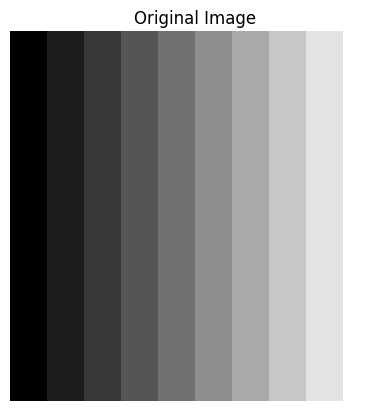

In [ ]:
# Assume known dimensions
shape = (10, 10)  # ← Adjust this to match the actual image size!

# Original image
original_image = byteArrayToGrayscaleImage(byte_array, shape)

# Display the image
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


In [ ]:
testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

# Encrypt the grayscale byte array using AES in CTR mode
cypherImageBytes = counterMode(byte_array, testKey, 1)

# Print the encrypted byte values
print("Cipher image bytes:\n", cypherImageBytes)
print()

# Decrypt the image by reapplying AES CTR with the same key and nonce
decryptedText = counterMode(cypherImageBytes, testKey, 1)

# Print the decrypted byte values (should match the original image)
print("Decrypted image bytes:\n", decryptedText)


7e 52 25 e3
59 33 a5 35
37 96 ad cb
9b 9d 2c 3e


1f d2 1e 2d
b0 09 e3 85
c2 ac ab eb
3b 91 8a cd


c2 b5 c7 29
4b 60 87 e7
fe ce e9 16
a9 46 ed 0f


cd 6c a9 f0
a4 56 69 b9
3d b6 30 91
7c 27 a1 6b


c9 1a 36 a0
36 c0 16 b2
b3 01 9e 02
35 f7 b1 c0


2e 68 82 c7
f9 83 c2 76
5b ef de 3a
d9 66 66 24


4c 09 43 c3
5a e3 57 3f
8b c3 3d 83
bf 8c 56 a9


Cipher image bytes:
 [126  75  23 168  61  78  51 154 255 119 173 210 169 214  72  67 137 125
 214 204 176  16 209 206 166 209  61  68 243 112 138 212 240 254 163  84
 221 207  79   6 254 215 219  93 205  59 123 160   5 141 169 233 150  29
  13 196 171  25 248 112 124  62 147  32 173 103 160  15 254  33  22 171
 129  74 250 127 163  88 121  33  46 113 176 140 157 254  84 217 147  14
 222  35 235  45   2  89 218 166 139  34]

7e 52 25 e3
59 33 a5 35
37 96 ad cb
9b 9d 2c 3e


1f d2 1e 2d
b0 09 e3 85
c2 ac ab eb
3b 91 8a cd


c2 b5 c7 29
4b 60 87 e7
fe ce e9 16
a9 46 ed 0f


cd 6c a9 f0
a4 56 69 b9
3d b6 30 91
7c 27 a1 6b


c9 1a 36 a0
36 c0 16 

## Transform bytes into greyscale image

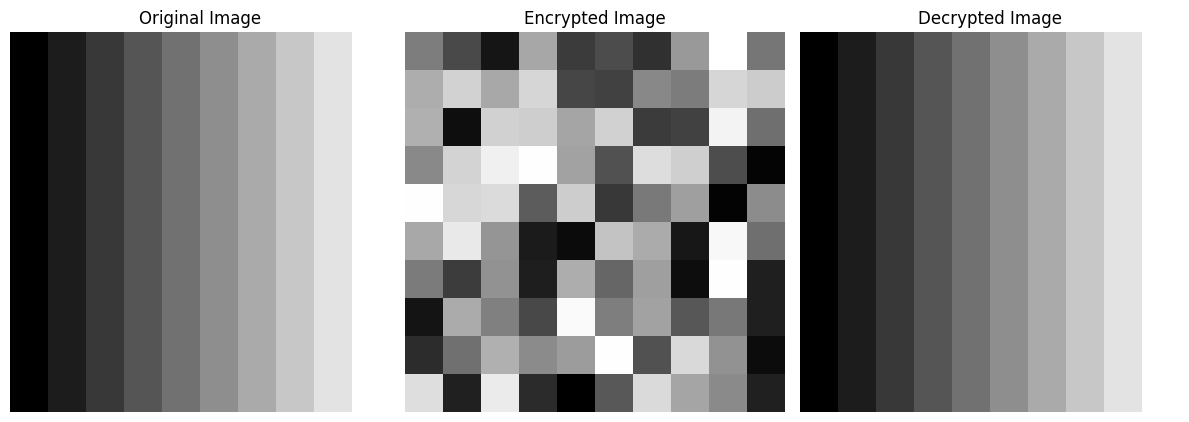

In [ ]:
# Assume known image dimensions

# Reconstruct images from byte arrays
encrypted_image = byteArrayToGrayscaleImage(cypherImageBytes, shape)
restored_image = byteArrayToGrayscaleImage(decryptedText, shape)

# Plot side by side
import matplotlib.pyplot as plt

# 1 row, 2 columns
fig, ax = plt.subplots(1, 3, figsize=(12, 6))  


# Left: original image
ax[0].imshow(original_image, cmap = "gray")
ax[0].set_title("Original Image")
ax[0].axis('off')

# Middle: encrypted image
ax[1].imshow(encrypted_image, cmap='gray')
ax[1].set_title("Encrypted Image")
ax[1].axis('off')

# Right: decrypted (original) image
ax[2].imshow(restored_image, cmap='gray')
ax[2].set_title("Decrypted Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
(original_image - restored_image).max(), (original_image - restored_image).min()

(0, 0)

## Galois Counter Mode

In [ ]:
irreducible_poly_128_bits = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1]

irreducible_poly_128 = galois.Poly(irreducible_poly_128_bits, field = GF2)
# Define the extension field GF(2^8) using the given irreducible polynomial
Gfield128 = galois.GF(2**128, irreducible_poly = irreducible_poly_128)

In [ ]:
def convertToBits(byte_array):
    return np.unpackbits(np.array(byte_array, dtype=np.uint8))

def convertBitsToBytes(bit_array):
    bit_array = np.array(bit_array, dtype=np.uint8)
    if len(bit_array) % 8 != 0:
        pad_len = 8 - (len(bit_array) % 8)
        bit_array = np.concatenate([bit_array, np.zeros(pad_len, dtype=np.uint8)])
    return np.packbits(bit_array)

def computeTag(cypherText , key, nonce):
    temp = cypherText

    nonceAsMatrix = Gfield(np.array(list(nonce.to_bytes(16, 'little'))).reshape(4, 4))

    # 0^128
    zero_block = Gfield(np.zeros((4, 4), dtype=int))

    # Step 1
    H = aesEncrypt(zero_block, key).flatten()   

    H_bits = convertToBits(H)
    
    # Convert H to GF(2^128)
    H_galois = Gfield128(np.array(H_bits, dtype=int))

    initalVector = Gfield128(convertToBits(aesEncrypt(nonceAsMatrix, key).flatten()))

    if len(temp) % 16 != 0:
        temp = np.append(temp, np.zeros(16 - len(temp) % 16, dtype=int))

    tag = Gfield128(convertToBits(temp[:16])) @ H_galois

    for i in range(1, (len(temp) // 16) - 1):
        tag = Gfield128(convertToBits(temp[i * 16 : (i + 1) * 16]) + tag) @ H_galois
    
    length = cypherText.size * 8

    # Convert length (int) to a 128-bit (16-byte) big-endian array, then to bits
    length_bytes = length.to_bytes(16, 'big')
    length_bits = np.unpackbits(np.frombuffer(length_bytes, dtype=np.uint8))
    # Convert length bits to Gfield128
    length_galois = Gfield128(length_bits)
    # Compute the final tag
    tag = (length_galois + tag) @ H_galois
    tag = tag + initalVector
    tag_bytes = convertBitsToBytes(tag)
    return tag_bytes



def gcmEncrypt(message, key, nonce):
    C = counterMode(message, key, nonce + 1)
    tag = computeTag(C, key, nonce)
    output = np.concatenate((C, tag))
    return output



## Test of GCM

In [ ]:
stateMatrix = Gfield(np.array([[0x32, 0x88, 0x31, 0xe0],
                                   [0x43, 0x5a, 0x31, 0x37],
                                   [0xf6, 0x30, 0x98, 0x07],
                                   [0xa8, 0x8d, 0xa2, 0x34]]))

testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

print("Message: ", stateMatrix, "\n")

# Encrypt the state matrix using GCM mode
encryptedMsg = gcmEncrypt(stateMatrix, testKey, 0)
print("Encrypted message: ", encryptedMsg, "\n")

# Split the encrypted message into the ciphertext and tag
recivedMsg = encryptedMsg[:-16]
recievedTag = encryptedMsg[-16:]

print("First 16 bits: ", recivedMsg, "\n")
print("Last 16 bits (tag): ", recievedTag, "\n")

# Compute the tag for the received message
computedTag = computeTag(recivedMsg, testKey, 0)
print("Computed tag: ", computedTag, "\n")

# Verify the tag
if np.array_equal(recievedTag, computedTag):
    print("By comparing the Computed tag with the last 16 tagbits the tag is valid, message integrity verified. \n")
else:
    print("By comparing the Computed tag with the last 16 tagbits, a tag mismatch is seen, message integrity compromised. \n")

#Create an error message
errorMessage = encryptedMsg

#Inject an error into the error message
errorMessage[0] = 125
print("A message with deliberately made error in the first byte: ", errorMessage, "\n")

# Split the error message into the received message and tag
recivedMsgError = errorMessage[:-16]
recievedTagError = errorMessage[-16:]


print("First 16 bits: ", recivedMsgError, "\n")
print("Last 16 bits (tag): ", recievedTagError, "\n")

# Compute the tag for the received message with error
computedTagError = computeTag(recivedMsgError, testKey, 0)
print("Computed tag: ", computedTagError, "\n")

# Verify the tag for the message with error
if np.array_equal(recievedTagError, computedTagError):
    print("By comparing the Computed tag with the last 16 tagbits the tag is valid, message integrity verified. \n")
else:
    print("By comparing the Computed tag with the last 16 tagbits, a tag mismatch is seen, message integrity compromised. \n")

Message:  [[ 50 136  49 224]
 [ 67  90  49  55]
 [246  48 152   7]
 [168 141 162  52]] 

7e 52 25 e3
59 33 a5 35
37 96 ad cb
9b 9d 2c 3e


Encrypted message:  [ 76 218  20   3  26 105 148   2 193 166  53 204  51  16 142  10 125  26
  62 185 247 184  66  27 107 153 240  84  12 179  71 111] 

First 16 bits:  [ 76 218  20   3  26 105 148   2 193 166  53 204  51  16 142  10] 

Last 16 bits (tag):  [125  26  62 185 247 184  66  27 107 153 240  84  12 179  71 111] 

Computed tag:  [125  26  62 185 247 184  66  27 107 153 240  84  12 179  71 111] 

By comparing the Computed tag with the last 16 tagbits the tag is valid, message integrity verified. 

A message with deliberately made error in the first byte:  [125 218  20   3  26 105 148   2 193 166  53 204  51  16 142  10 125  26
  62 185 247 184  66  27 107 153 240  84  12 179  71 111] 

First 16 bits:  [125 218  20   3  26 105 148   2 193 166  53 204  51  16 142  10] 

Last 16 bits (tag):  [125  26  62 185 247 184  66  27 107 153 240  84  12